In [8]:
import pytesseract
import pandas as pd
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from threading import Thread
import concurrent.futures

%matplotlib inline

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

## File Path

In [16]:
IMAGE_PATH = "../datafiles/Page_2.jpg"
imageMAT = Image.open(IMAGE_PATH)

## Get blocks

In [17]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

In [7]:
def get_noise_val_Image(imagePIL, NoiseThreshold_ppage): # NoiseThreshold_ppage is b/w 0 and 1
    '''
    Params:
        imagePIL - PIL image object
        NoiseThreshold_ppage - %age noise threshold for an image range [0, 1]
        
    Returns:
        ratio of dark pixels and total pixels
        boolean page acceptance result based on noise ratio
        binary image with 0 representing noise pixels    
    '''
    
    BinaryThreshold = 195          #will come from config file
    
    
    # matcopy = imagePIL.copy()
    grayPIL = imagePIL.convert('LA')
    imageNUMPY = np.array(grayPIL, dtype='uint8')
    
    Tessstart = time.time()
    data_result = pytesseract.image_to_data(imagePIL, lang='eng')
    print("Tess EndTime taken", time.time() - Tessstart)
    
    data_lines = ([s_inner.split() for s_inner in data_result.splitlines()])
    df = pd.DataFrame(data_lines[1:], columns = data_lines[0])
    df = df.dropna()
    
    
    # DFFORstart = time.time()
    for index, row in df.iterrows():
        r = int(row['top']); r_ = r + int(row['height'])
        c = int(row['left']); c_ = c + int(row['width'])
        imageNUMPY[r:r_, c:c_, :] = 255
    # print("DFFOR EndTime taken", time.time() - DFFORstart)
    
    #bin_ = rgb2gray(imageNUMPY)
    bin_ = np.zeros(imageNUMPY.shape)
    
    bin_ = np.where(bin_ > BinaryThreshold, 1, 0)
    
    pixels_num = bin_.shape[0]*bin_.shape[1]
    ratio = (pixels_num - bin_.sum())/pixels_num
    
    return ratio, ratio > NoiseThreshold_ppage, bin_ #returns the ratio, rejection result, binary_Image

In [ ]:
def get_noise_params_PDF(PDFImages, NoiseThreshold_ppage  = 0.50):
    ''' IN-PROGRESS
    PDFImages: r x c x ch x num where num is number of 
    '''
    PAGESCOUNT = len(PDFImages)
    pageNoiseFlag = [0]*PAGESCOUNT   #should be a class prop

    FORstart = time.time()
    
    for i in range(0, len(PDFImages)):
        #ITstart = time.time()
        if(get_noise_val_Image(PDFImages[i], NoiseThreshold_ppage)[1]): #rejection means: page is noisy
            pageNoiseFlag[i] = 1
        #print("Iteration-Time taken", time.time() - ITstart)
    
    print("FOR EndTime taken", time.time() - FORstart)
    
    return   sum(pageNoiseFlag)/PAGESCOUNT, pageNoiseFlag #returns the %age of pages that are noisy [0, 1]

### Using the functions

In [28]:
R, r, I = get_noise_val_Image(imageMAT, 0.50)

0.9990941176470588 True


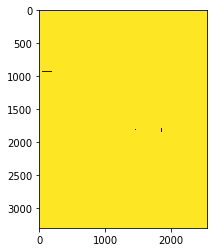

In [36]:
# print(R, r)

# plt.imshow(I)
# plt.show()